In [1]:
# imports
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [2]:
# loading and preprocessing
data = pd.read_csv('face_features_with_curvatures.csv')
features = data.drop(columns=['infant_id', 'frame_id'])
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [3]:
print("Data type of features_scaled elements:", features_scaled.dtype)

Data type of features_scaled elements: float64


In [4]:
# apply PCA to the standardized data
pca = PCA(n_components=0.95)  # Retain 95% of variance
principal_components = pca.fit_transform(features_scaled)

# number of components selected
n_components = pca.n_components_
print(f'Number of components selected: {n_components}')

Number of components selected: 6


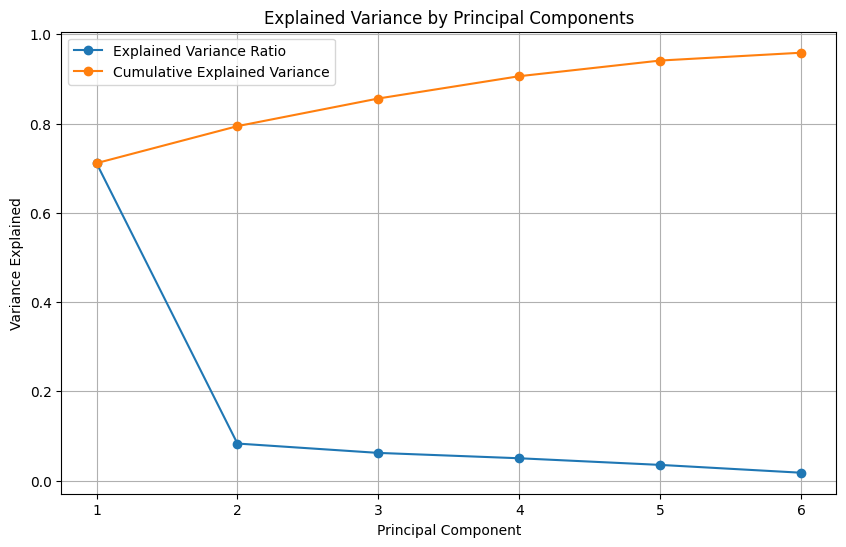

In [5]:
# explained variance ratio and cumulative explained variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = explained_variance_ratio.cumsum()

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', label='Explained Variance Ratio')
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', label='Cumulative Explained Variance')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.title('Explained Variance by Principal Components')
plt.legend()
plt.grid(True)
plt.show()


                                   PC1       PC2       PC3       PC4  \
mean_y_coord_left_brow       -0.000900 -0.749351  0.017046 -0.013362   
mean_y_coord_right_brow       0.254094  0.080047  0.001442 -0.002815   
right_eye_eyelid_distance     0.214388  0.378831 -0.055675  0.015703   
left_eye_eyelid_distance      0.234774 -0.095833 -0.077465 -0.007154   
lip_distance                  0.206070  0.444199 -0.023254 -0.002845   
right_eye_closed             -0.064586  0.018656  0.675232  0.005220   
left_eye_closed              -0.038860  0.068795  0.718359  0.052202   
mouth_closed                 -0.008019 -0.017207 -0.042124  0.998256   
curvature_upper_right_brow    0.260392 -0.046489  0.041025  0.001435   
curvature_lower_right_brow    0.258063 -0.063490  0.008978 -0.002788   
curvature_upper_left_brow     0.263105 -0.058698  0.027848 -0.000002   
curvature_lower_left_brow     0.256655 -0.119079  0.047136  0.000721   
curvature_upper_left_eyelid   0.260058 -0.062268  0.046519  0.00

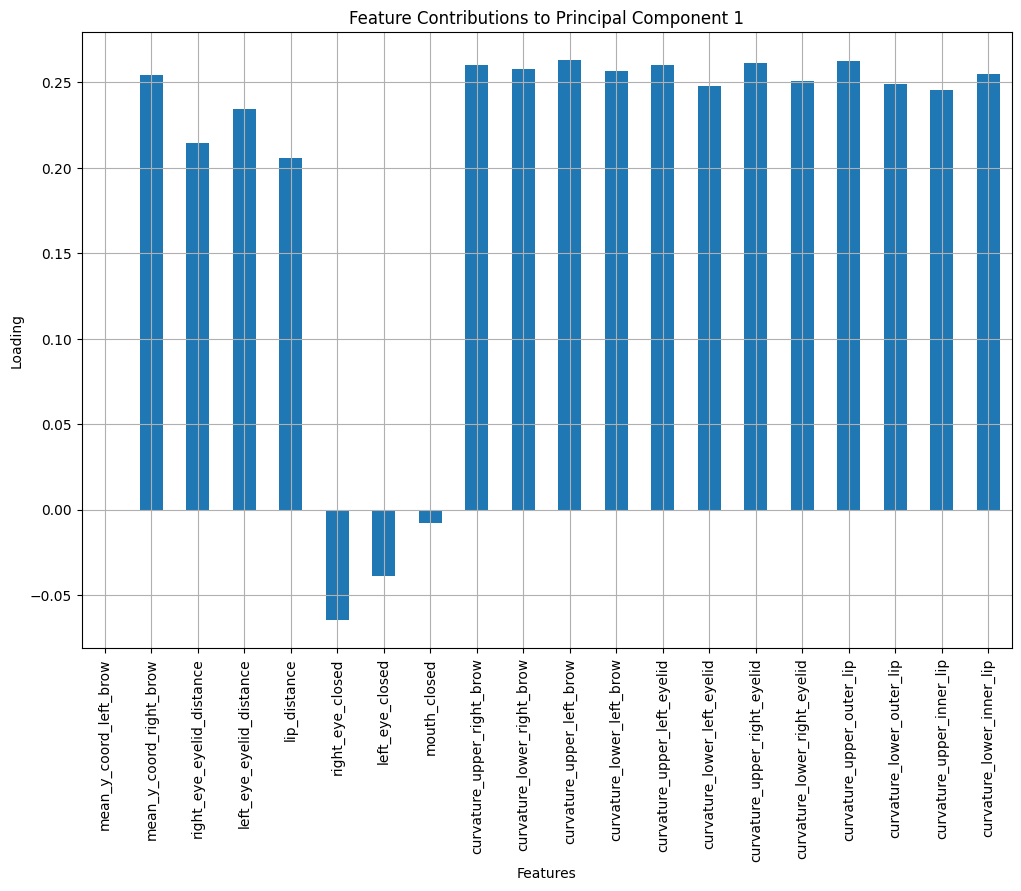

In [6]:
loadings = pca.components_

# dataFrame for the loadings
loadings_df = pd.DataFrame(loadings.T, columns=[f'PC{i+1}' for i in range(n_components)], index=features.columns)

print(loadings_df)

# plotting
plt.figure(figsize=(12, 8))
loadings_df['PC1'].plot(kind='bar')
plt.title('Feature Contributions to Principal Component 1')
plt.xlabel('Features')
plt.ylabel('Loading')
plt.grid(True)
plt.show()

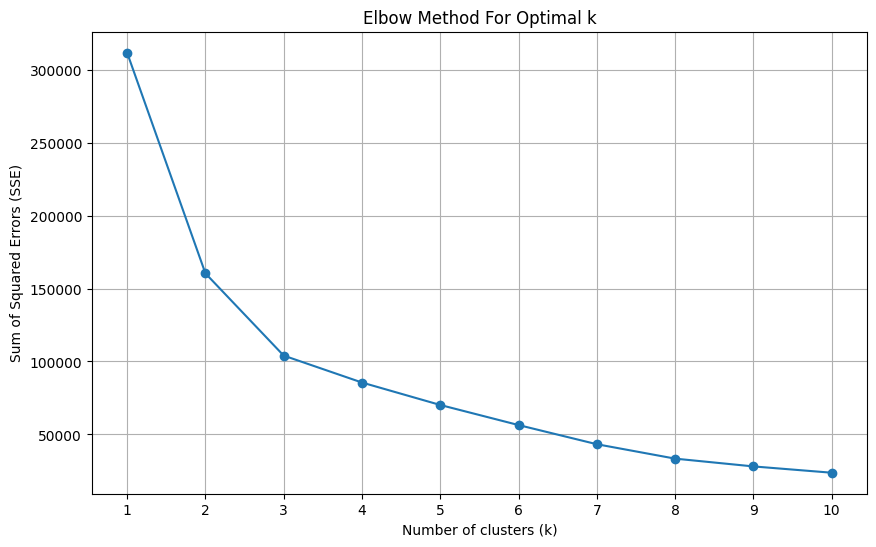

In [7]:
# determine the optimal number of clusters using the elbow method
sse = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(principal_components)
    sse.append(kmeans.inertia_)

# plotting
plt.figure(figsize=(10, 6))
plt.plot(k_range, sse, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method For Optimal k')
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [8]:
optimal_k = 3  # choose based on your elbow plot

# K-Means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
data['cluster'] = kmeans.fit_predict(principal_components)

grouped_data = data.drop(columns=['infant_id', 'frame_id']).groupby('cluster').mean()

# analyze the clusters
print(grouped_data)

         mean_y_coord_left_brow  mean_y_coord_right_brow  \
cluster                                                    
0                      7.340501                14.578356   
1                      4.610692                58.865763   
2                      9.425779                26.505219   

         right_eye_eyelid_distance  left_eye_eyelid_distance  lip_distance  \
cluster                                                                      
0                         1.703707                  1.714750      1.955579   
1                        11.551249                  6.508409     13.866995   
2                         3.622224                  3.607405      4.458320   

         right_eye_closed  left_eye_closed  mouth_closed  \
cluster                                                    
0                0.125882          0.04183      0.002841   
1                0.000000          0.00000      0.000000   
2                0.001154          0.00000      0.000000   

       

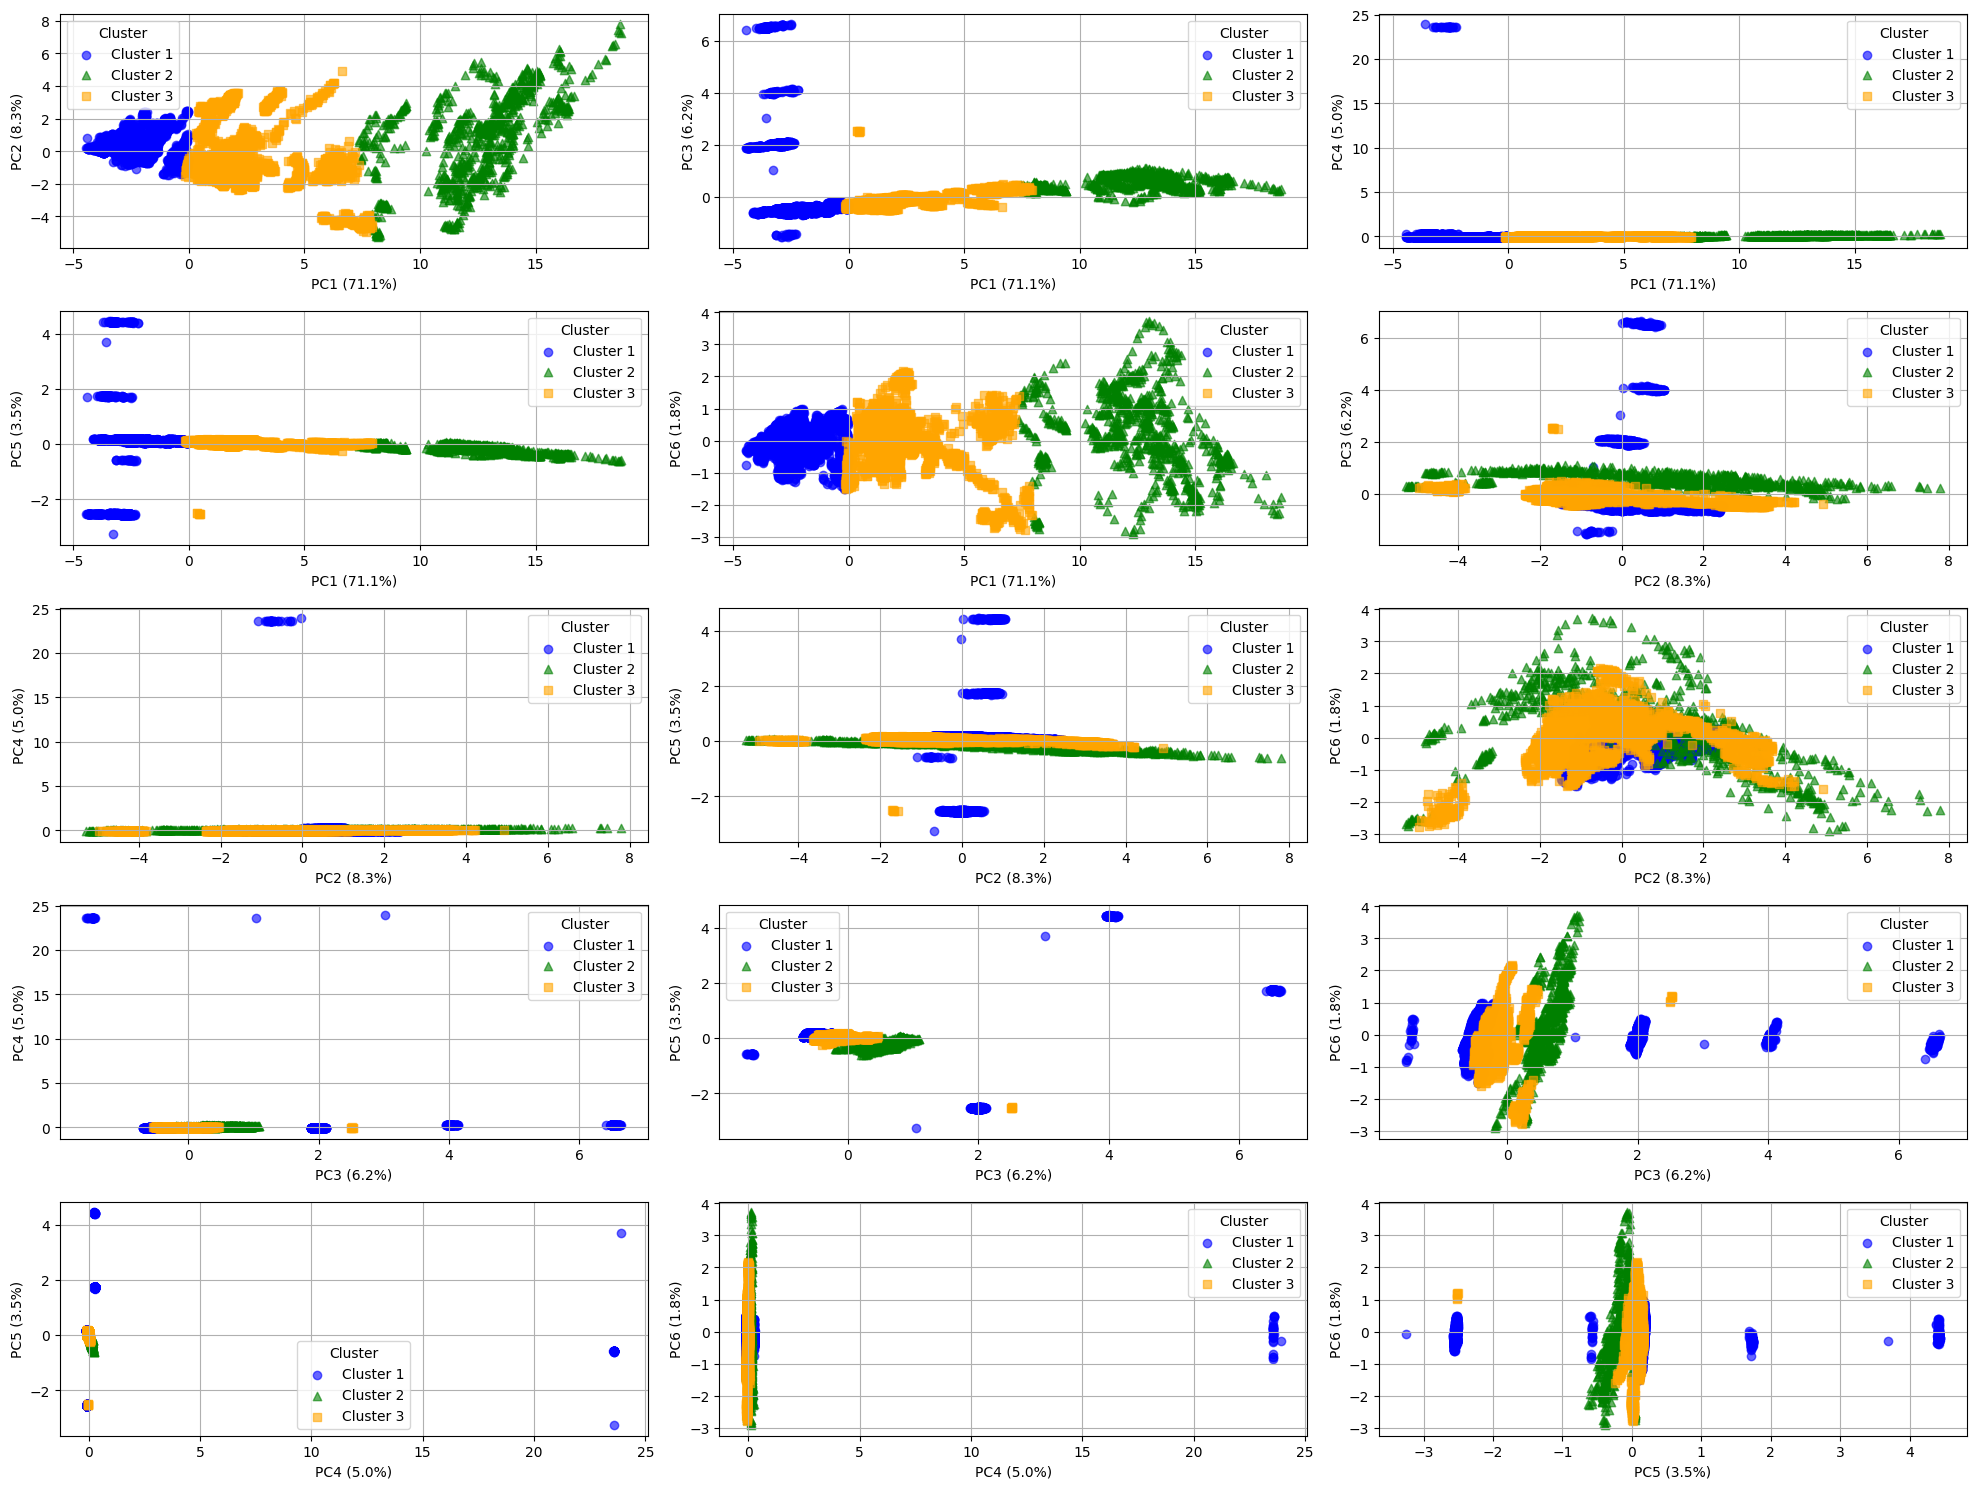

In [9]:
from itertools import combinations
num_components= 6 

pca = PCA(n_components=num_components)  
principal_components = pca.fit_transform(features_scaled)

# df with the PCA components
pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(num_components)])

# K-Means clustering
optimal_k = 3  # see above
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
pca_df['cluster'] = kmeans.fit_predict(principal_components)

data['cluster'] = pca_df['cluster']
colors = ['blue', 'green', 'orange']
markers = ['o', '^', 's']

# plotting the clusters pairwise
plt.figure(figsize=(20, 15))
pairwise_combinations = list(combinations(range(num_components), 2))
for i, (x_idx, y_idx) in enumerate(pairwise_combinations):
    plt.subplot(5, 3, i + 1)  
    for cluster in range(optimal_k):
        cluster_data = pca_df[pca_df['cluster'] == cluster]
        plt.scatter(cluster_data[f'PC{x_idx+1}'], cluster_data[f'PC{y_idx+1}'], 
                    c=colors[cluster], marker=markers[cluster], 
                    label=f'Cluster {cluster + 1}', alpha=0.6)
    plt.xlabel(f'PC{x_idx+1} ({pca.explained_variance_ratio_[x_idx]*100:.1f}%)')
    plt.ylabel(f'PC{y_idx+1} ({pca.explained_variance_ratio_[y_idx]*100:.1f}%)')
    plt.legend(title='Cluster')
    plt.grid(True)

plt.tight_layout()
plt.show()

In [46]:
# mapping from clusters to emotion labels
cluster_to_emotion = {
    0: 'calm',
    1: 'Surprised',
    2: 'Moderately Expressive'
}


data['emotion'] = data['cluster'].map(cluster_to_emotion)
data.drop(columns=['cluster'], inplace=True)

# resulting DataFrame
print(data.head())

   infant_id  frame_id  mean_y_coord_left_brow  mean_y_coord_right_brow  \
0          0      1052               26.348788                17.127944   
1          0      1053               26.198250                17.315864   
2          0      1054               26.715033                17.514939   
3          0      1055               26.413779                17.454999   
4          0      1056               26.339764                17.688944   

   right_eye_eyelid_distance  left_eye_eyelid_distance  lip_distance  \
0                   5.550000                  2.809016      4.694662   
1                   5.347490                  2.865359      4.537808   
2                   5.421089                  2.763375      4.664919   
3                   5.608964                  2.973785      4.289533   
4                   5.519994                  2.826190      4.047135   

   right_eye_closed  left_eye_closed  mouth_closed  ...  \
0             False            False         False  ...  

In [47]:
print(data)

       infant_id  frame_id  mean_y_coord_left_brow  mean_y_coord_right_brow  \
0              0      1052               26.348788                17.127944   
1              0      1053               26.198250                17.315864   
2              0      1054               26.715033                17.514939   
3              0      1055               26.413779                17.454999   
4              0      1056               26.339764                17.688944   
...          ...       ...                     ...                      ...   
16250        369      1918               33.724684                43.118234   
16251        369      1919               34.059471                43.134465   
16252        369      1920               34.205876                42.740573   
16253        369      1921               33.659804                42.891995   
16254        369      1922               32.333658                43.686978   

       right_eye_eyelid_distance  left_eye_eyelid_d

In [48]:
emotion_counts = data['emotion'].value_counts()
print(emotion_counts)

Neutral                  10217
Moderately Expressive     5188
Surprised                  850
Name: emotion, dtype: int64


In [49]:
data.to_csv('kmeans_labels.csv', index=False)